In [1]:
# Import libraries
import pickle
import http.client, urllib.parse
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fastai.tabular.all as fastai
np.set_printoptions(linewidth=130)
import torch
import json

load_dotenv()
key = os.getenv('API_KEY')

# longLats pickle
def load_pkl():
  longLats = pickle.load(open('./longLat.pkl', 'rb'))
  print(f"longLats loaded. {len(longLats)}")
  return longLats
def dump_pkl(longLats):
    pickle.dump(longLats, open('./longLat.pkl', 'wb'))
    print(f"pickle dumped. {len(longLats)}")
longLats = load_pkl()

# clean up data: area, date, floor, price
def load_csv():
  #return pd.read_csv('./data/Woodlands_June22_May23.csv')
  return pd.read_csv('./data/resale-flat-from-jan-2017.csv')
floor_dict = { f'0{i*3+1} TO 0{i*3+3}' if i < 3 else f'{i*3+1} TO {i*3+3}': i*3+2  for i in range(17)  }
def floor_cleanup(df):
  df['floor'] = df.storey_range.apply(lambda x:float(floor_dict[x]) if isinstance(x,str) else x)
  df.drop(['storey_range'], axis=1, inplace=True)
  return df
date_dict = { f'20{17+i}-0{j+1}' if j < 9 else f'20{17+i}-{j+1}': i*12+j  for i in range(7) for j in range(12)  }
def date_cleanup(df):
  df['date'] = df.month.apply(lambda x:float(date_dict[x]) if isinstance(x,str) else x)
  df.drop(['month'], axis=1, inplace=True)
  return df
def load_and_cleanup():
  df = load_csv()
  df = floor_cleanup(df)
  df = date_cleanup(df)
  return df

df = load_and_cleanup()
df.describe()
date_max = df.date.max()
town = 'Geylang'
df = df[(df.town==town.replace('_', ' ').upper()) & (df.date > date_max-12)]

from pathlib import Path
file = Path(f'./data/{town}_June22_May23.csv')
df.to_csv(file,index=False)
df


longLats loaded. 4731


,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
128339,GEYLANG,2 ROOM,109,ALJUNIED CRES,45.0,Improved,1986,62 years 11 months,238000.0,11.0,65.0
128340,GEYLANG,2 ROOM,45,CIRCUIT RD,42.0,Standard,1971,47 years 08 months,240000.0,5.0,65.0
128341,GEYLANG,2 ROOM,45,CIRCUIT RD,42.0,Standard,1971,47 years 08 months,240000.0,8.0,65.0
128342,GEYLANG,2 ROOM,70,CIRCUIT RD,42.0,Standard,1969,45 years 08 months,250000.0,11.0,65.0
128343,GEYLANG,3 ROOM,32,BALAM RD,57.0,Standard,1973,50 years 01 month,270000.0,5.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
152869,GEYLANG,5 ROOM,14,EUNOS CRES,117.0,Standard,1977,53 years,640000.0,14.0,76.0
152870,GEYLANG,5 ROOM,45,JLN TIGA,110.0,Improved,2005,81 years 01 month,916000.0,2.0,76.0
152871,GEYLANG,5 ROOM,7,PINE CL,111.0,Improved,2000,76 years 02 months,1058000.0,14.0,76.0
152872,GEYLANG,EXECUTIVE,846,SIMS AVE,147.0,Maisonette,1985,61 years 05 months,992288.0,17.0,76.0


In [2]:
blk_street = df.block + ' ' + df.street_name

longLats = load_pkl()
responses = []
errors = []
count = 0

conn = http.client.HTTPConnection('api.positionstack.com')
for i,add in enumerate(blk_street.unique()):
    params = urllib.parse.urlencode({
        'access_key': key,
        'query': add,
        'region': 'Singapore',
        'limit': 1,
    })
    conn.request('GET', '/v1/forward?{}'.format(params))
    res = conn.getresponse()
    data = res.read()
    dataList = json.loads(data.decode('utf-8'))['data']
    if (len(dataList)==0): 
      print(f"check {add}. No data returned")
      count += 1
      errors.append(add)
      continue
    first_response = dataList[0]
    responses.append(first_response)
    if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
      longLats[f"{add}"] = (first_response['longitude'], first_response['latitude'])
      if (i%10==0): print(f"{i} of {len(blk_street.unique())}")
    else:
      print(f"check {add}. {first_response['label']}. confidence of {first_response['confidence']}")
      count += 1
      errors.append(add)

print(f"{count} errors detected")
dump_pkl(longLats)


longLats loaded. 4731
0 of 211
10 of 211
20 of 211
30 of 211
check 47 JLN TIGA. 47 Jln Tambur, Singapore. confidence of 0.8
check 49 JLN TIGA. 49 Jln Tambur, Singapore. confidence of 0.8
check 45 JLN TIGA. 45 Jln Tambur, Singapore. confidence of 0.8
40 of 211
50 of 211
check 97 JLN DUA. 67 Jln Tambur, Singapore. confidence of 0.8
60 of 211
check 43 JLN TIGA. 43 Jln Tambur, Singapore. confidence of 0.8
70 of 211
check 39 JLN TIGA. 39 Jln Tambur, Singapore. confidence of 0.8
80 of 211
90 of 211
100 of 211
110 of 211
120 of 211
130 of 211
140 of 211
150 of 211
check 93 JLN DUA. 67 Jln Tambur, Singapore. confidence of 0.8
160 of 211
170 of 211
180 of 211
190 of 211
200 of 211
210 of 211
7 errors detected
pickle dumped. 4935


In [6]:
#df[(df.street_name=='JLN DUA')|(df.street_name=='JLN TIGA')].block.unique()
df = df[(df.street_name!='JLN DUA')&(df.street_name!='JLN TIGA')].copy()
df.describe()

,floor_area_sqm,lease_commence_date,resale_price,floor,date
count,647.000000,647.000000,6.470000e+02,647.000000,647.000000
mean,81.652859,1984.205564,5.082906e+05,7.902628,70.496136
std,25.205764,13.991575,2.078440e+05,4.394773,3.322626
min,40.000000,1967.000000,2.170000e+05,2.000000,65.000000
25%,60.000000,1975.000000,3.249440e+05,5.000000,68.000000
50%,83.000000,1982.000000,4.600000e+05,8.000000,71.000000
75%,93.500000,1986.000000,6.694440e+05,11.000000,73.000000
max,160.000000,2018.000000,1.100000e+06,20.000000,76.000000


In [7]:
file = Path(f'./data/{town}_June22_May23_without_newest.csv')
df.to_csv(file,index=False)
df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
128339,GEYLANG,2 ROOM,109,ALJUNIED CRES,45.0,Improved,1986,62 years 11 months,238000.0,11.0,65.0
128340,GEYLANG,2 ROOM,45,CIRCUIT RD,42.0,Standard,1971,47 years 08 months,240000.0,5.0,65.0
128341,GEYLANG,2 ROOM,45,CIRCUIT RD,42.0,Standard,1971,47 years 08 months,240000.0,8.0,65.0
128342,GEYLANG,2 ROOM,70,CIRCUIT RD,42.0,Standard,1969,45 years 08 months,250000.0,11.0,65.0
128343,GEYLANG,3 ROOM,32,BALAM RD,57.0,Standard,1973,50 years 01 month,270000.0,5.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
152868,GEYLANG,5 ROOM,28,CASSIA CRES,120.0,Improved,1998,74 years 02 months,925000.0,5.0,76.0
152869,GEYLANG,5 ROOM,14,EUNOS CRES,117.0,Standard,1977,53 years,640000.0,14.0,76.0
152871,GEYLANG,5 ROOM,7,PINE CL,111.0,Improved,2000,76 years 02 months,1058000.0,14.0,76.0
152872,GEYLANG,EXECUTIVE,846,SIMS AVE,147.0,Maisonette,1985,61 years 05 months,992288.0,17.0,76.0


In [8]:
def lat_long(df):
  adds = (df.block + ' ' + df.street_name)
  longLat = adds.apply(lambda x: longLats[x])
  df['long'] = longLat.apply(lambda x: x[0])
  df['lat'] = longLat.apply(lambda x: x[1])
  return df
lat_long(df)
df.describe()

,floor_area_sqm,lease_commence_date,resale_price,floor,date,long,lat
count,647.000000,647.000000,6.470000e+02,647.000000,647.000000,647.000000,647.000000
mean,81.652859,1984.205564,5.082906e+05,7.902628,70.496136,103.891050,1.321464
std,25.205764,13.991575,2.078440e+05,4.394773,3.322626,0.007970,0.006655
min,40.000000,1967.000000,2.170000e+05,2.000000,65.000000,103.875584,1.307130
25%,60.000000,1975.000000,3.249440e+05,5.000000,68.000000,103.885602,1.317029
50%,83.000000,1982.000000,4.600000e+05,8.000000,71.000000,103.887610,1.322753
75%,93.500000,1986.000000,6.694440e+05,11.000000,73.000000,103.899670,1.326473
max,160.000000,2018.000000,1.100000e+06,20.000000,76.000000,103.905016,1.331416


SuggestedLRs(valley=0.0020892962347716093, slide=6.309573450380412e-07)

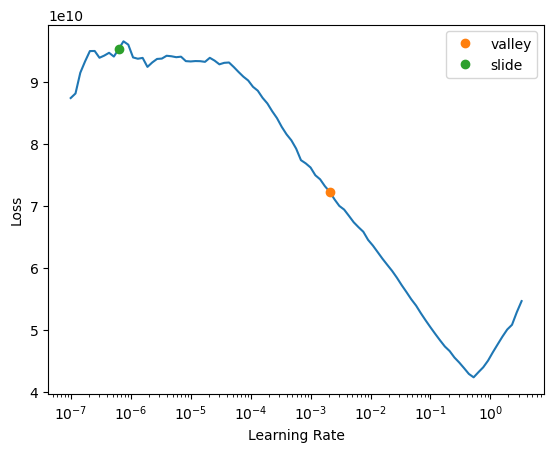

In [9]:
dls = fastai.TabularDataLoaders.from_df(df,procs=[fastai.Normalize],cont_names=["floor", "floor_area_sqm", "lease_commence_date", "date", "lat","long"],y_names=["resale_price"])
#dls.show_batch()
def MSE(yhat,y):
  return torch.mean(torch.square(yhat-y))
def RMSE(yhat,y):
  return torch.sqrt(MSE(yhat,y))
learn = fastai.tabular_learner(dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),loss_func=MSE,metrics=RMSE)
learn.lr_find(suggest_funcs=(fastai.valley,fastai.slide))


In [17]:
learn = fastai.tabular_learner(
  dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),
  loss_func=MSE,metrics=RMSE,
  cbs=[fastai.SaveModelCallback(),fastai.EarlyStoppingCallback(patience=5)]
)
learn.fit_one_cycle(100,8e-2)
learn.validate()


Better model found at epoch 0 with valid_loss value: 38476.7734375.


(#2) [1487828352.0,38476.7734375]

In [18]:
# predict prices on map
row = df.drop(['resale_price'], axis=1).iloc[0].copy()
cats = ['floor', 'floor_area_sqm', 'lease_commence_date', 'date']
for cat in cats:
  row[cat] = df[cat].median()
latMin, latMax = df.lat.min(),df.lat.max()
latLeft = latMin - (latMax-latMin)/10
latRight = latMax + (latMax-latMin)/10
longMin, longMax = df.long.min(),df.long.max()
longLeft = longMin - (longMax-longMin)/10
longRight = longMax + (longMax-longMin)/10
n1 = 6*20
n2 = 6*20
longs = np.linspace(longLeft, longRight, n1)
lats = np.linspace(latLeft, latRight, n2)
prices = np.ndarray((n2,n1))
for i,lat in enumerate(lats):
  if i%10==0: print(f"{i} of {n2}") 
  row['lat'] = lat
  for j,long in enumerate(longs):
    row['long'] = long
    with learn.no_bar(), learn.no_logging():
      _, yPred, _ = learn.predict(row)
      prices[i][j] = yPred.item()
print('done!')

0 of 120
10 of 120
20 of 120
30 of 120
40 of 120
50 of 120
60 of 120
70 of 120
80 of 120
90 of 120
100 of 120
110 of 120
done!


In [19]:
import http.client, urllib.parse
import json

mrts = ["Aljunied MRT", "Paya Lebar MRT", "Eunos MRT", "Mountbatten MRT", "Dakota MRT", "MacPherson MRT", "Mattar MRT", "Ubi MRT"]
longLats = load_pkl()

responses = []
for mrt in mrts:
	conn = http.client.HTTPConnection('api.positionstack.com')
	params = urllib.parse.urlencode({
		'access_key': key,
		'query': mrt[:-4] + ' Station',
		'region': 'Singapore',
		'limit': 1,
	})
	conn.request('GET', '/v1/forward?{}'.format(params))
	res = conn.getresponse()
	data = res.read()
	dataList = json.loads(data.decode('utf-8'))['data']
	if (len(dataList)==0): 
		print(f"check {add}. No data returned")
		count += 1
		errors.append(add)
		continue
	first_response = dataList[0]
	responses.append(first_response)
	if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
		longLats[f"{mrt}"] = (first_response['longitude'], first_response['latitude'])
		print(f"{first_response['label']}, confidence {first_response['confidence']}")
	else:
		print(f"check {mrt}. {first_response['label']}. confidence of {first_response['confidence']}")

dump_pkl(longLats)


longLats loaded. 5382
Aljunied Station, Singapore, confidence 1
Paya Lebar Station, Singapore, confidence 1
Eunos Station, Singapore, confidence 1
Mountbatten, Singapore, confidence 1
Dakota Station, Singapore, confidence 1
MacPherson Station, Singapore, confidence 1
Opposite Mattar Station Exit A, Singapore, confidence 1
Ubi Station, Singapore, confidence 1
pickle dumped. 5389


In [18]:
longLats['Upper Changi MRT']

(103.96138, 1.341393)

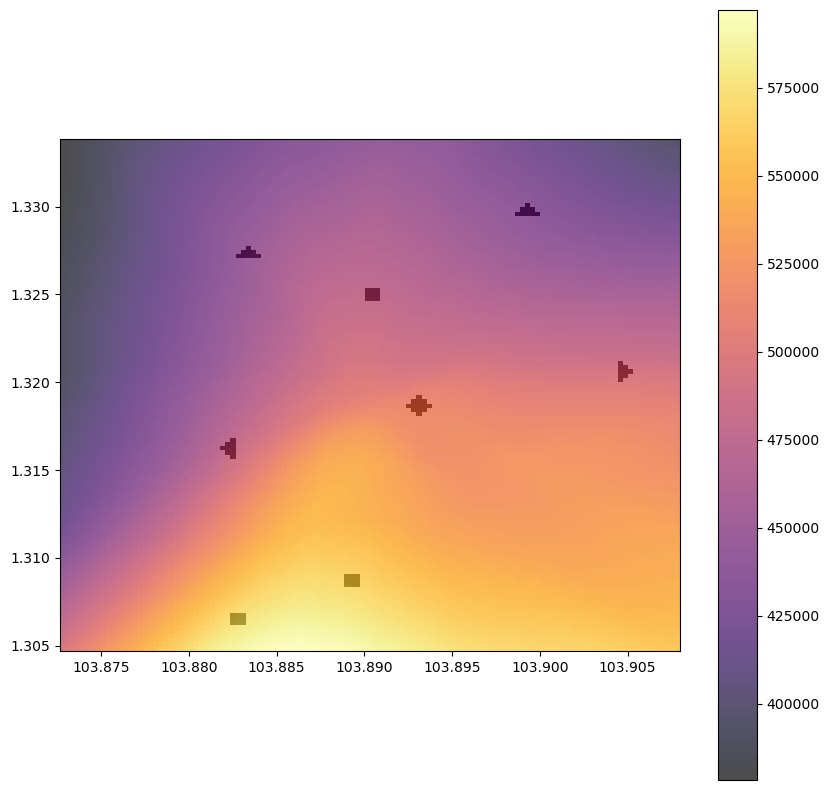

In [20]:
def min_coords(long,lat):
  return (np.abs((longs-long)).argmin(), np.abs(lats-lat).argmin())
def map_left(i,j):
  mrt_map[j-2][i+1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+2][i+1]=1
def map_sq(i,j):
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i-1]=1
def map_right(i,j):
  mrt_map[j-2][i-1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+2][i-1]=1
def map_up(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j-1][i-2]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+2]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
def map_down(i,j):
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i-2]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+1][i+2]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i]=1
def map_star(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j][i-2]=1
  mrt_map[j][i+2]=1
  mrt_map[j+2][i]=1
  mrt_map[j-2][i]=1
mrt_map = np.zeros((n2,n1))

map_left(*min_coords(*longLats[mrts[0]]))
map_star(*min_coords(*longLats[mrts[1]]))
map_right(*min_coords(*longLats[mrts[2]]))
map_sq(*min_coords(*longLats[mrts[3]]))
map_sq(*min_coords(*longLats[mrts[4]]))
map_sq(*min_coords(*longLats[mrts[5]]))
map_up(*min_coords(*longLats[mrts[6]]))
map_up(*min_coords(*longLats[mrts[7]]))
#map_down(*min_coords(*longLats[mrts[1]]))
#map_left(*min_coords(*longLats[mrts[2]]))
#map_right(*min_coords(*longLats[mrts[3]]))
#map_right(*min_coords(*longLats[mrts[4]]))

fig,ax=plt.subplots()
#mrt
#color map
shw2 = ax.imshow(mrt_map, extent=[longLeft, longRight, latLeft, latRight], origin='lower',cmap='Greys',alpha=1.0)
shw = ax.imshow(prices, extent=[longLeft, longRight, latLeft, latRight], origin='lower',alpha=0.7, cmap='inferno')
bar = plt.colorbar(shw)
fig.set_figwidth(10)
fig.set_figheight(10/n1*n2)

plt.show()

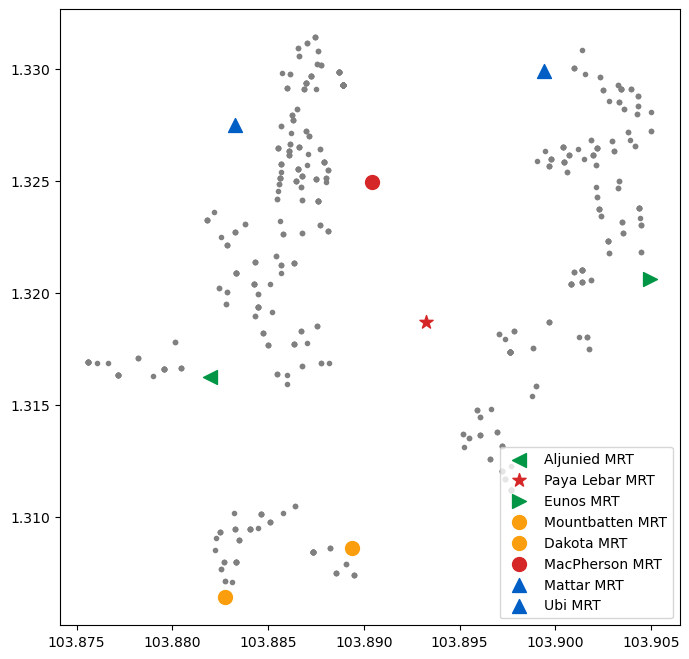

In [27]:
circle = "#FA9E0D"
ew = "#009645"
dt = "#005EC4"
red = '#d62728'
markers = ["<", '*', ">", 'o', 'o', 'o', '^', '^']
colors = [ew, red, ew, circle, circle, red, dt, dt]

fig,ax2=plt.subplots()
ax2.scatter(df.long,df.lat,marker='.',c="Gray")
for i,mrt in enumerate(mrts):
  ax2.scatter([longLats[mrt][0]], [longLats[mrt][1]],marker=markers[i],c=colors[i],label=mrt,s=100)
ax2.legend(loc='lower right')
fig.set_figwidth(8)
fig.set_figheight(8/n1*n2)

plt.show()

for mrt in mrts:
  (i,j) = min_coords(*longLats[mrt])
